# Computing venusquake detection probabilities from a balloon platform
The code computes the probability of observing a signal with SNR > threshold at a given location or along a balloon trajectory for a variety of seismicity scenarios.

## Building detection maps

In [1]:
%matplotlib widget
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd

import sys
sys.path.append('/staff/quentin/Documents/Projects/2024_Venus_Detectability/Venus_Detectability')
import proba_modules as pm
reload(pm)

<module 'proba_modules' from '/staff/quentin/Documents/Projects/2024_Venus_Detectability/Venus_Detectability/proba_modules.py'>

### Rayleigh wave infrasound

In [60]:
from scipy import interpolate
file_atmos = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/Venus_Detectability/data/profile_VCD_for_scaling_pd.csv'
profile = pd.read_csv(file_atmos)
f_rho = interpolate.interp1d(profile.altitude/1e3, profile.rho, kind='quadratic')
f_t = interpolate.interp1d(profile.altitude/1e3, profile.t, kind='quadratic')
f_gamma = interpolate.interp1d(profile.altitude/1e3, profile.gamma, kind='quadratic')
f_c = interpolate.interp1d(profile.altitude/1e3, profile.c, kind='quadratic')

In [536]:
reload(pm)
dir_GF = '/projects/restricted/infrasound/data/infrasound/2023_Venus_inversion/'
file_curve = f'{dir_GF}GF_Dirac_1Hz_combined_wHot40.csv'
alt_balloon = 50.
opt_TL = dict(
    rho0=f_rho(0.), 
    rhob=f_rho(alt_balloon), 
    cb=f_c(alt_balloon), 
    unknown='pressure', 
    model='Cold100'
)
TL_new, TL_new_qmin, TL_new_qmax = pm.get_TL_curves_precomputed(file_curve, **opt_TL)

In [332]:
file_slopes = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/Venus_Detectability/data/Venus_data/distribution_venus_per_mw.csv'
pd_slopes = pm.get_slopes(file_slopes)

"""
setting = 'active_low_min'
cat_quake = 'coronae'
popt = pd_slopes.loc[(pd_slopes.type_setting==setting), cat_quake].values
poly1d = np.poly1d(popt)
func = lambda mw: 10**poly1d(mw)

Mws = np.linspace(3.5, 8.7, 1000)
ylim = [1e-2, 10e6]
xlim = [Mws.min(), Mws.max()]
plt.figure(facecolor='none')
plt.plot(Mws, func(Mws), linewidth=3., color='red', linestyle='--')
plt.yscale('log')
#plt.xlim(xlim)
#plt.ylim(ylim)
#plt.gca().set_facecolor('none')
"""

"\nsetting = 'active_low_min'\ncat_quake = 'coronae'\npopt = pd_slopes.loc[(pd_slopes.type_setting==setting), cat_quake].values\npoly1d = np.poly1d(popt)\nfunc = lambda mw: 10**poly1d(mw)\n\nMws = np.linspace(3.5, 8.7, 1000)\nylim = [1e-2, 10e6]\nxlim = [Mws.min(), Mws.max()]\nplt.figure(facecolor='none')\nplt.plot(Mws, func(Mws), linewidth=3., color='red', linestyle='--')\nplt.yscale('log')\n#plt.xlim(xlim)\n#plt.ylim(ylim)\n#plt.gca().set_facecolor('none')\n"

In [95]:
def merge_and_fix_surface_ratio_region(pattern, regions=['corona', 'rift', 'ridge', 'intraplate'], set_minradius_to_zero=True, write=False):

    ## e.g., pattern = './data/surface_ratios_{region}_active.csv'

    all_data = pd.DataFrame()
    for region in regions:
        data = pd.read_csv(pattern.format(region), header=[0])
        data['region'] = region
        all_data = pd.concat([all_data, data])
    all_data.reset_index(drop=True, inplace=True)

    iloc = -1
    for _, group in all_data.groupby(['lon', 'lat']):
        iloc += 1
        all_data.loc[all_data.index.isin(group.index), 'iloc'] = iloc

    if set_minradius_to_zero:
        all_data.loc[all_data.iradius==0, 'ratio'] = 0.
        all_data.loc[all_data.iradius==0, 'ratio_map'] = 0.

    all_data.loc[all_data.lon < 0, 'lon'] += 360.

    if write:
        all_data.to_csv(pattern.format('all'), header=True, index=False)

    return all_data

### Venusquakes: Iris' model

In [331]:
file_ratio = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/Venus_Detectability/data/surface_ratios/surface_ratios_active_fixed.csv'
surface_ratios = pm.get_surface_ratios(file_ratio)

"""
for iloc in range(1):
    surface_ratios_loc = surface_ratios.loc[surface_ratios['iloc']==iloc]
    plt.figure()
    for region, surface_ratios_loc_reg in surface_ratios_loc.groupby('region'):
        plt.plot(surface_ratios_loc_reg.radius, surface_ratios_loc_reg.ratio_map)
"""

"\nfor iloc in range(1):\n    surface_ratios_loc = surface_ratios.loc[surface_ratios['iloc']==iloc]\n    plt.figure()\n    for region, surface_ratios_loc_reg in surface_ratios_loc.groupby('region'):\n        plt.plot(surface_ratios_loc_reg.radius, surface_ratios_loc_reg.ratio_map)\n"

In [251]:
pattern = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/data/surface_ratios/surface_ratios_network_{}_active.csv'
#pattern = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/data/surface_ratios/surface_ratios_network_balloon_20.0_50.0_same_event_{}_active.csv'
surface_ratios = merge_and_fix_surface_ratio_region(pattern, regions=['corona', 'rift', 'ridge', 'intraplate'], write=False)

In [601]:
reload(pm)

dlat = 5.
r_venus = 6052
opt_model = dict(
    scenario = 'active_low_min', # Iris' seismicity scenario
    dists = np.arange(10., np.pi*r_venus, 200), # Low discretization will lead to terrible not unit integrals
    M0s = np.linspace(3., 8., 30), # Low discretization will lead to terrible not unit integrals
    SNR_thresholds = np.linspace(0.1, 10., 50),
    noise_level = 1e-2, # noise level in Pa
    duration = 1./(365.*24.), # (1/mission_duration)
    all_lats = np.arange(-89, 90, dlat),
    all_lons = np.arange(0, 359, dlat*2),
    #all_lats = np.arange(-90., 90.+dlat, dlat),
    #all_lons = np.arange(-180, 180+dlat*2, dlat*2),
    homogeneous_ratios = False,
    m_min = 3.,
    r_venus = r_venus,
    #verbose=False
    nb_CPU=1
)

freq = 1. # Or None
apply_fc_correction = None
#proba_model = pm.proba_model(pd_slopes, surface_ratios, TL_new[freq], TL_new_qmin[freq], TL_new_qmax[freq], apply_fc_correction=apply_fc_correction)
#proba_model.compute_proba_map(**opt_model)
proba_model = pm.proba_model_CPUs(pd_slopes, surface_ratios, TL_new[freq], TL_new_qmin[freq], TL_new_qmax[freq], apply_fc_correction=apply_fc_correction)
proba_model.compute_scores_across_CPUs(**opt_model)

Running serial


100%|██████████| 36/36 [05:04<00:00,  8.47s/it]


### Venusquakes: Airglow

In [188]:
pattern = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/data/surface_ratios/surface_ratios_nightglow_dayglow_SNRnight10.0_SNRday1_same_event_{}_active.csv'
#pattern = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/data/surface_ratios/surface_ratios_nightglow_dayglow_SNRnight1.0_SNRday1_same_event_{}_active.csv'
pattern = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/data/surface_ratios/surface_ratios_nightglow_dayglow_SNRnight1.0_SNRday0.0_same_event_{}_active.csv'
pattern = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/data/surface_ratios/surface_ratios_nightglow_dayglow_SNRnight10.0_SNRday0.0_same_event_{}_active.csv'
pattern = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/data/surface_ratios/surface_ratios_nightglow_SNRnight10.0_SNRday1.0_same_event_{}_active.csv'
pattern = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/data/surface_ratios/surface_ratios_nightglow_SNRnight1.0_SNRday1.0_same_event_{}_active.csv'
pattern = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/data/surface_ratios/surface_ratios_dayglow_SNRnight1.0_SNRday1.0_same_event_{}_active.csv'
pattern = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/data/surface_ratios/surface_ratios_dayglow_SNRnight10.0_SNRday1.0_same_event_corrected_{}_active.csv'
pattern = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/data/surface_ratios/surface_ratios_nightglow_SNRnight1.0_SNRday1_same_event_mCold100_{}_active.csv'
surface_ratios_periods = merge_and_fix_surface_ratio_region(pattern, regions=['corona', 'rift', 'ridge', 'intraplate'], write=False)

In [ ]:
folder_shp = 'airglow_shp'
network = 'dayglow_SNRnight1.0_SNRday1.0_same_event'
ext = 'shp'

file_shp = f'./data/{folder_shp}/{network}.{ext}'
gdf_onlydayglow = gpd.read_file(file_shp)

In [ ]:
def get_n_colors(n, cmap_name='viridis'):
    cmap = plt.get_cmap(cmap_name)
    return [cmap(i) for i in np.linspace(0, 1, n)]

plt.figure()
n = 1
colors = get_n_colors(n, cmap_name='tab10')
offset = 0
lonmin=120
for ii in np.arange(n):
    #poly_gen = gdf.loc[gdf.lon_0>120].iloc[offset+ii].geometry
    entry = gdf_onlydayglow.loc[gdf_onlydayglow.lon_0>lonmin].iloc[offset+ii]
    poly_gen = entry.geometry
    label_opt = dict(label=entry.distance)
    entry_10 = gdf_10.loc[gdf_10.lon_0>lonmin].iloc[offset+ii]
    poly_gen_10 = entry_10.geometry
    label_opt_10 = dict(label=entry.distance)
    
    if False:
        try:
            for poly in poly_gen_10.geoms:
                coords = np.array(poly.exterior.coords)
                plt.plot(coords[:,0], coords[:,1], color=colors[ii], ls='--', )
        except:
            coords = np.array(poly_gen_10.exterior.coords)
            plt.plot(coords[:,0], coords[:,1], color=colors[ii], ls=':',)
    
    if True:
        try:
            for poly in poly_gen.geoms:
                coords = np.array(poly.exterior.coords)
                #plt.scatter(coords[:,0], coords[:,1], color=colors[ii], s=10, **label_opt)
                plt.plot(coords[:,0], coords[:,1], color=colors[ii], **label_opt)
                label_opt = {}
        except:
            coords = np.array(poly_gen.exterior.coords)
            #plt.scatter(coords[:,0], coords[:,1], color=colors[ii], ls=':', s=10, **label_opt)
            plt.plot(coords[:,0], coords[:,1], color=colors[ii], ls=':', **label_opt)
plt.legend()
factor = 1.6e7
nightglow_lon = 180.
dayglow_lon = 0.
plt.scatter(factor*entry.lon_0/180., 0, marker='x', c='red', s=100)
plt.scatter(factor*dayglow_lon/180., 0, marker='o', c='green', s=100)
plt.scatter(factor*nightglow_lon/180., 0, marker='o', c='blue', s=100)
plt.title(f'{entry.lat_0} | {entry.lon_0}')

In [319]:
reload(pm)

dlat = 5.
r_venus = 6052
opt_model = dict(
    scenario = 'active_high_min', # Iris' seismicity scenario
    dists = np.arange(10., np.pi*r_venus, 200), # Low discretization will lead to terrible not unit integrals
    M0s = np.linspace(3., 8., 30), # Low discretization will lead to terrible not unit integrals
    SNR_thresholds = np.linspace(0.1, 10., 50),
    noise_level = 1e-2, # noise level in Pa
    duration = 1./(365.*24.), # (1/mission_duration)
    all_lats = np.arange(-89, 90, dlat),
    #all_lats = np.array([0]),
    all_lons = np.arange(0, 359, dlat*2),
    homogeneous_ratios = False,
    m_min = 3.,
    r_venus = r_venus,
)

freq = 1.
apply_fc_correction = None #freq

#pattern = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/data/surface_ratios/surface_ratios_dayglow_SNRnight1.0_SNRday1_same_event_corrected_{}_active.csv'
pattern = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/data/surface_ratios/surface_ratios_dayglow_SNRnight1.0_SNRday1_same_event_mCold100_{}_active.csv'
surface_ratios_periods = merge_and_fix_surface_ratio_region(pattern, regions=['corona', 'rift', 'ridge', 'intraplate'], write=False)
proba_model_dayglow = pm.proba_model(pd_slopes, surface_ratios_periods.loc[surface_ratios_periods.period==1./freq], TL_new[freq], TL_new_qmin[freq], TL_new_qmax[freq], apply_fc_correction=apply_fc_correction)
proba_model_dayglow.compute_proba_map(**opt_model)

#pattern = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/data/surface_ratios/surface_ratios_nightglow_SNRnight1.0_SNRday1_same_event_corrected_{}_active.csv'
pattern = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/data/surface_ratios/surface_ratios_nightglow_SNRnight1.0_SNRday1_same_event_mCold100_{}_active.csv'
surface_ratios_periods = merge_and_fix_surface_ratio_region(pattern, regions=['corona', 'rift', 'ridge', 'intraplate'], write=False)
proba_model_nightglow = pm.proba_model(pd_slopes, surface_ratios_periods.loc[surface_ratios_periods.period==1./freq], TL_new[freq], TL_new_qmin[freq], TL_new_qmax[freq], apply_fc_correction=apply_fc_correction)
proba_model_nightglow.compute_proba_map(**opt_model)

 39%|███▉      | 14/36 [00:21<00:33,  1.53s/it]


KeyboardInterrupt: 

In [198]:
from scipy import interpolate
import pyproj
from tqdm import tqdm
def compute_proba_cte_velocity_traj(lons, snrs, proba_profile, vel_horiz, duration_months=6, init_location=(0,0), azimuth=90., R0=6052000):
    
    g = pyproj.Geod(proj='robin', lat_0=0., lon_0=0., a=R0, b=R0)   
    duration_hours = np.arange(duration_months*30*24)
    distances = duration_hours*vel_horiz*1e3*3600
    n_distances = len(distances)
    lat, lon = np.repeat(init_location[0], n_distances), np.repeat(init_location[1], n_distances)
    angles = np.tile(azimuth, n_distances)
    endlon, _, _ = g.fwd(lon, lat, angles, distances)
    endlon[endlon<0] += 360.
    
    probas_traj = np.zeros((snrs.size, duration_hours.size))
    for isnr, snr in tqdm(enumerate(snrs), total=snrs.size):
        f_proba_vs_lon = interpolate.interp1d(lons, proba_profile[isnr,:], kind='quadratic', bounds_error=False, fill_value=(proba_profile[isnr,0], proba_profile[isnr,-1]))
        
        probas_traj_loc = f_proba_vs_lon(endlon)
        probas_traj[isnr,:] = 1. - np.cumprod(1. - probas_traj_loc)
        
    return duration_hours, endlon, probas_traj

lons = proba_model_dayglow.all_lons
snrs = proba_model_dayglow.SNR_thresholds
vel_horiz = 0.3
proba_profile = proba_model_dayglow.proba_all[:,0,:]
duration_hours, endlon, probas_traj_dayglow = compute_proba_cte_velocity_traj(lons, snrs, proba_profile, vel_horiz, duration_months=6, init_location=(0,0), azimuth=90.)

proba_profile = proba_model_nightglow.proba_all[:,0,:]
duration_hours, endlon, probas_traj_nightglow = compute_proba_cte_velocity_traj(lons, snrs, proba_profile, vel_horiz, duration_months=6, init_location=(0,0), azimuth=90.)

100%|██████████| 50/50 [00:00<00:00, 1685.22it/s]


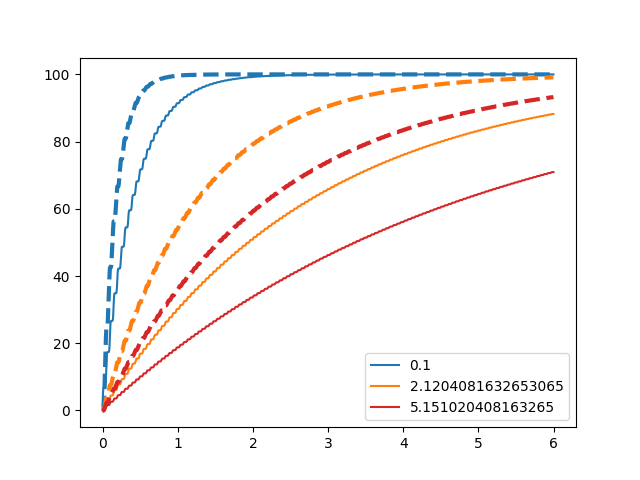

In [191]:
plt.figure()
colors = ['tab:blue', 'tab:orange', 'tab:red']
for ii, isnr in enumerate([0, 10, 25]):
    plt.plot(duration_hours/(30*24), probas_traj_dayglow[isnr,:]*1e2, label=snrs[isnr], color=colors[ii])
    plt.plot(duration_hours/(30*24), probas_traj_nightglow[isnr,:]*1e2, ls='--', lw=3, color=colors[ii])
    #plt.scatter(endlon, probas_traj*1e2, c=duration_hours/(30*24))
plt.legend()

In [199]:
SNRS, DUR = np.meshgrid(snrs, duration_hours)
probas_airglow = pd.DataFrame(np.c_[SNRS.ravel(), DUR.ravel(), (probas_traj_nightglow.T).ravel()], columns=['SNR', 'hour', 'proba'])
#probas_airglow.to_csv(f'./data/final_probas/probas_nightglow_SNRnight1.0_SNRday1.0_same_event_corrected_{freq}Hz.csv', header=True, index=False)
probas_airglow.to_csv(f'./data/final_probas/probas_nightglow_SNRnight1.0_SNRday1_same_event_mCold100_{freq}Hz_nobrune.csv', header=True, index=False)

probas_airglow = pd.DataFrame(np.c_[SNRS.ravel(), DUR.ravel(), (probas_traj_dayglow.T).ravel()], columns=['SNR', 'hour', 'proba'])
#probas_airglow.to_csv(f'./data/final_probas/probas_dayglow_SNRnight1.0_SNRday1.0_same_event_corrected_{freq}Hz.csv', header=True, index=False)
probas_airglow.to_csv(f'./data/final_probas/probas_dayglow_SNRnight1.0_SNRday1_same_event_mCold100_{freq}Hz_nobrune.csv', header=True, index=False)

### Venusquakes: Wrinkle Ridges

In [325]:
file_slopes = './Venus_Detectability/data/wrinkle_ridges/distribution_venus_per_mw_wrinkles.csv'
pd_slopes_wrinkles = pm.get_slopes(file_slopes)

file_ratio = './Venus_Detectability/data/surface_ratios/surface_ratios_wrinkles_fixed.csv'
surface_ratios_wrinkles = pm.get_surface_ratios(file_ratio)

"""
file_ratio = './data/surface_ratios_wrinkles.csv'
surface_ratios = pd.read_csv(file_ratio, header=[0])
surface_ratios['region'] = 'wrinkle_ridges'

iloc = -1
for _, group in surface_ratios.groupby(['lon', 'lat']):
    iloc += 1
    surface_ratios.loc[surface_ratios.index.isin(group.index), 'iloc'] = iloc
surface_ratios.to_csv('./data/surface_ratios_wrinkles_fixed.csv', header=True, index=False)
"""

"\nfile_ratio = './data/surface_ratios_wrinkles.csv'\nsurface_ratios = pd.read_csv(file_ratio, header=[0])\nsurface_ratios['region'] = 'wrinkle_ridges'\n\niloc = -1\nfor _, group in surface_ratios.groupby(['lon', 'lat']):\n    iloc += 1\n    surface_ratios.loc[surface_ratios.index.isin(group.index), 'iloc'] = iloc\nsurface_ratios.to_csv('./data/surface_ratios_wrinkles_fixed.csv', header=True, index=False)\n"

In [ ]:
setting = pd_slopes.type_setting.iloc[0]
cat_quake = 'wrinkle_ridges'
popt = pd_slopes.loc[(pd_slopes.type_setting==setting), cat_quake].values
poly1d = np.poly1d(popt)
func = lambda mw: 10**poly1d(mw)

Mws = np.linspace(3.5, 8.7, 1000)
ylim = [1e-2, 10e6]
xlim = [Mws.min(), Mws.max()]
plt.figure(facecolor='none')
plt.plot(Mws, func(Mws), linewidth=3., color='red', linestyle='--')
plt.yscale('log')
plt.xlim(xlim)
plt.ylim(ylim)
plt.gca().set_facecolor('none')

In [326]:
reload(pm)

dlat = 5.
r_venus = 6052
opt_model = dict(
    scenario = 'wrinkle_ridges', # Leah's seismicity scenario
    dists = np.arange(10., np.pi*r_venus, 200), # Low discretization will lead to terrible not unit integrals
    M0s = np.linspace(3., 8., 30), # Low discretization will lead to terrible not unit integrals
    SNR_thresholds = np.linspace(0.1, 10., 50),
    noise_level = 1e-2, # noise level in Pa
    duration = 1./(365.*24.), # (1/mission_duration)
    all_lats = np.arange(-89, 90, dlat),
    all_lons = np.arange(0, 359, dlat*2),
    homogeneous_ratios = False,
    m_min = 3.,
    r_venus = r_venus,
)

freq = 1.
proba_model_wrinkles = pm.proba_model_wrinkles(pd_slopes_wrinkles, surface_ratios_wrinkles, TL_new[freq], TL_new_qmin[freq], TL_new_qmax[freq])
proba_model_wrinkles.compute_proba_map(**opt_model)

100%|██████████| 36/36 [01:16<00:00,  2.13s/it]


### Volcanoes: volcanic seismicity + epicentral infrasound

In [ ]:
import proba_modules as pm
reload(pm)

file_volcano = './data/Venus_data/05_large_greaterthan100.csv'
volcanoes = pm.get_volcano_locations(file_volcano)

file_slopes = './data/Venus_data/distribution_venus_per_VEI.csv'
pd_slopes = pm.get_slopes(file_slopes)

file_curve = './data/GF_data/GF_reverse_fault_1Hz.csv'
TL_new, TL_new_qmin, TL_new_qmax = pm.get_TL_curves_with_EI(file_curve, dist_min=100., alt_balloon=50.)

file_ratio = './data/GF_data/surface_ratios_fixed.csv'
surface_ratios = pm.get_surface_ratios(file_ratio)

dlat = 5.
r_venus = 6052
lat_volcanoes = volcanoes['Lat_Center'].values
lon_volcanoes = volcanoes['Lon_Center'].values
opt_model = dict(
    scenario = 'active_high', # Iris' seismicity scenario
    dists = None, # dists not provided for Volcanoes beca
    M0s = np.linspace(0., 6., 30), # VEIs - Low discretization will lead to terrible not unit integrals
    SNR_thresholds = np.linspace(0.1, 10., 50),
    noise_level = 5e-2, # noise level in Pa
    duration = 1./(365.*24.), # (1/mission_duration)
    all_lats = np.arange(-90., 90.+dlat, dlat),
    all_lons = np.arange(-180, 180+dlat*2., dlat*2.),
    homogeneous_ratios = False,
    m_min = 0.,
    r_venus = r_venus,
    return_rate=True, 
    rates_provided=None, 
)

proba_model_volcanoes = pm.proba_model_volcano(lat_volcanoes, lon_volcanoes, pd_slopes, surface_ratios, TL_new, TL_new_qmin, TL_new_qmax)
proba_model_volcanoes.compute_proba_map(**opt_model)

## Trajectories

### New model

In [589]:
R0 = 6371000  # Venus radius in meters
#lat_offset, lon_offset = np.linspace(-50., 50., 80), np.linspace(-50., 50., 40)
#lat_offset = np.linspace(-65., 65., 25)
lat_offset = np.linspace(-85., 85., 25)
lon_offset = np.linspace(-180., 179., 30)
#lat_offset = np.linspace(85., -85., 2)
#lon_offset = np.linspace(-6.6, 10., 2)
mission_duration = (12./12.)*365*24*3600

LAT_offset, LON_offset = np.meshgrid(lat_offset, lon_offset)
LAT_offset_shape = LAT_offset.shape
LAT_offset, LON_offset = LAT_offset.ravel(), LON_offset.ravel()

dt = 1*3600/6.
times = np.arange(0, mission_duration, dt)  # Time vector from 0 to 3600 seconds in steps of 600 seconds
TIMES, ID_LAT0 = np.meshgrid(times, np.arange(LAT_offset.size))
shape_TIMES = TIMES.shape # balloon init loc/t0 x balloon flight time 
TIMES, ID_LAT0 = TIMES.ravel(), ID_LAT0.ravel() 

In [380]:
file_atmos = './Venus_Detectability/data/VCD_atmos_globe_new.dat'
winds = VCD.get_winds(file_atmos, alt_balloon*1e3)
wind_direction_interpolator, wind_strength_interpolator, _ = VCD.get_winds_interpolator(file_atmos, alt_balloon*1e3, winds=winds)

/staff/quentin/Documents/Projects/2024_Venus_Detectability/Venus_Detectability/VCD_trajectory_modules.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winds['gid'] = winds.groupby(['lat', 'lon'])['val'].transform('idxmin')
/staff/quentin/Documents/Projects/2024_Venus_Detectability/Venus_Detectability/VCD_trajectory_modules.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winds['wind_strength'] = winds.groupby(['lat', 'lon'])['val'].transform(lambda x: np.sqrt(sum(x**2)))
/staff/quentin/Documents/Pro

In [637]:
from scipy.interpolate import RectBivariateSpline

all_lats = opt_model['all_lats']
all_lons = opt_model['all_lons']
snrs = opt_model['SNR_thresholds']
snr_targets = [1., 2., 5.]
interpolators = dict()
for snr_target in snr_targets:
    proba_snr = proba_model.proba_all[np.argmin(abs(snrs-snr_target)),:,:]
    interpolators[snr_target] = RectBivariateSpline(all_lons, all_lats, proba_snr, kx=1, ky=1)

In [648]:
reload(pm)

mission_duration = 60.
inputs = 0, LAT_offset, LON_offset
times_b, lons_b, lats_b, probas_b = pm.compute_multiple_trajectories_allprobas_vectorized(mission_duration, interpolators, wind_direction_interpolator, wind_strength_interpolator, inputs)

100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


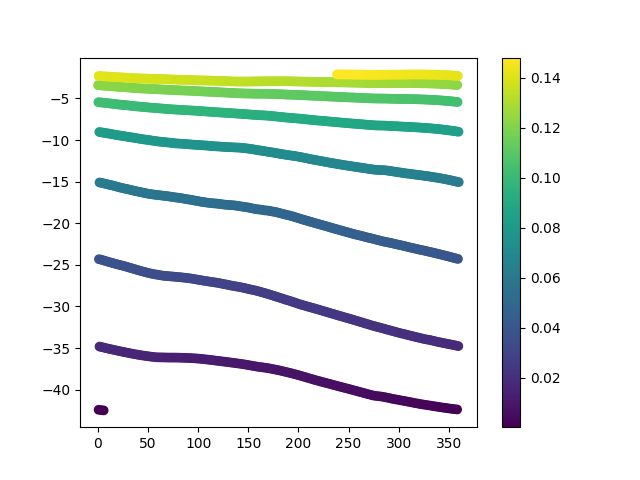

In [658]:
ipos = np.argmin(np.sqrt((LAT_offset-(-45.))**2+(LON_offset-0.)**2))
isnr = 2

plt.figure()
sc = plt.scatter(lons_b[ipos,:], lats_b[ipos,:], c=probas_b[isnr,ipos,:])
#sc = plt.scatter(lons_b[ipos,:], lats_b[ipos,:], c=times_b/(24*3600))
plt.colorbar(sc)

In [569]:
import proba_volcanoes_modules as pvm 
reload(pvm)

latitudes, longitudes = pvm.compute_positions_vectorized_w_interpolator(LAT_offset[ID_LAT0].reshape(shape_TIMES), LON_offset[ID_LAT0].reshape(shape_TIMES), wind_direction_interpolator, wind_strength_interpolator, TIMES.reshape(shape_TIMES), R0)
longitudes[longitudes<0] += 360.

100%|██████████| 52559/52559 [01:15<00:00, 697.41it/s]


In [593]:
reload(pm)

inputs = 0, LAT_offset, LON_offset
mission_durations = [30., 60., 90., 120., 240., 360.]
pd_final_probas = pm.compute_multiple_trajectories_vectorized(mission_durations, interpolators, wind_direction_interpolator, wind_strength_interpolator, R0, inputs)

0it [00:00, ?it/s]
100%|██████████| 3/3 [00:00<00:00, 68.52it/s]


In [587]:
toplot = interpolator.ev(longitudes, latitudes).reshape(shape_TIMES)

In [590]:
probas_int = 1.-np.cumprod(1.-toplot.reshape(shape_TIMES)[:,::int(3600/dt)], axis=1)

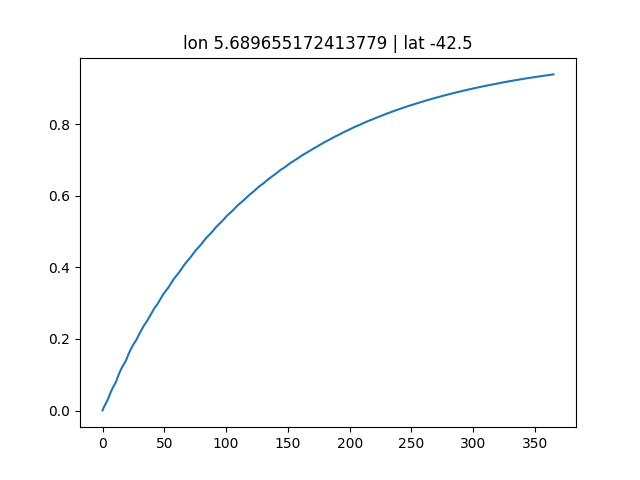

In [592]:
id = np.argmin(np.sqrt((LAT_offset-(-45.))**2+(LON_offset-0.)**2))

dt = times[1]-times[0]
#probas_int = 1.-np.cumprod(1.-toplot.reshape(shape_TIMES)[:,::int(3600/dt)], axis=1)
#dt_probas_int = np.gradient(probas_int, times[::int(3600/dt)])
plt.figure()
plt.title(f'lon {LON_offset[id]} | lat {LAT_offset[id]}')
plt.plot(times[::int(3600/dt)]/(3600*24), probas_int[id,:])
#plt.plot(times[::int(3600/dt)]/(3600*24), dt_probas_int)
#lon_loc = longitudes.reshape(shape_TIMES)[id,:]
#lon_loc[lon_loc>180] -= 360.
#plt.plot(times/(3600*24), lon_loc, color='black')
#plt.plot(times/(3600*24), latitudes.reshape(shape_TIMES)[id,:], color='tab:red')
#sc = plt.scatter(longitudes.reshape(shape_TIMES)[id,:], latitudes.reshape(shape_TIMES)[id,:], c=probas_int)
#plt.colorbar(sc)
#plt.plot(trajectory.time/(3600*24), trajectory.lat, color='red', ls='--')
#plt.plot(trajectory.time/(3600*24), trajectory.lon, color='black', ls='--')

### Old model

In [255]:
import VCD_trajectory_modules as VCD
from importlib import reload
reload(VCD)

<module 'VCD_trajectory_modules' from '/staff/quentin/Documents/Projects/2024_Venus_Detectability/Venus_Detectability/VCD_trajectory_modules.py'>

In [484]:
reload(VCD)
start_lon = 0.
dlon = 2.
trajectory = VCD.compute_trajectory_airglow(start_lon, dlon, velocity_imager=-0.32, time_max=3600*24)

#plt.figure()
#sc = plt.scatter(trajectory.lon, trajectory.lat, c=trajectory.time)
#plt.colorbar(sc)

In [258]:
reload(VCD)

file_atmos = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/Venus_Detectability/data/VCD_atmos_globe_new.dat'
altitude = alt_balloon*1e3
winds = VCD.get_winds(file_atmos, altitude)

/staff/quentin/Documents/Projects/2024_Venus_Detectability/Venus_Detectability/VCD_trajectory_modules.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winds['gid'] = winds.groupby(['lat', 'lon'])['val'].transform('idxmin')
/staff/quentin/Documents/Projects/2024_Venus_Detectability/Venus_Detectability/VCD_trajectory_modules.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winds['wind_strength'] = winds.groupby(['lat', 'lon'])['val'].transform(lambda x: np.sqrt(sum(x**2)))
/staff/quentin/Documents/Pro

In [506]:
reload(VCD)

start_location = [-45.,0.] # lat, lon
#start_location = [45.,0.] # lat, lon
#start_location = [85.,0.] # lat, lon
#start_location = [-45.,90.] # lat, lon
start_location = [85., -6.6] # lat, lon
opt_trajectory = dict(
    time_max=3600*24*30*2,
    save_trajectory=False,
    folder = './data/',
)
trajectory = VCD.compute_trajectory(winds, start_location, **opt_trajectory)

#file = './data/trajectory_balloon_lat0.00_lon0.00_15days.csv'
#file = './data/trajectory_balloon_lat50.00_lon50.00_15days.csv'
#trajectory = pd.read_csv(file, header=[0])

## Visualization

### Venusquakes - Map

In [ ]:
reload(pm)

PATH_VENUS_DATA = os.path.join("/staff/quentin/Documents/Projects/2024_Venus_Detectability/Venus_Detectability/data/")
PATH_VENUS = os.path.join(f"{PATH_VENUS_DATA}Venus_data/tectonic_settings_Venus")
VENUS = {
    'corona': gpd.read_file(f"{PATH_VENUS}/corona.shp"),
    'rift': gpd.read_file(f"{PATH_VENUS}/rifts.shp"),
    'ridge': gpd.read_file(f"{PATH_VENUS}/ridges.shp"),
}

opt_visualization = dict(
    VENUS = VENUS,
    c_cbar = 'black', 
    l_snr_to_plot = [1.,2.5], 
    n_colors = 10,
    plot_all_regions = False,
    use_active_corona = True
)

## active high
"""
opt_visualization.update(dict(
    low_cmap = np.arange(0.05, 0.35, 0.05), # 1 day RW low activity
    high_cmap = np.arange(0.6, 1.2, 0.1),))
"""
## active low
"""
opt_visualization.update(dict(
    low_cmap = np.arange(0.4, 0.6, 0.05), # 1 day RW low activity
    high_cmap = np.arange(0.6, 1.6, 0.1),))
"""

pm.plot_map(proba_model, **opt_visualization)

### Venusquakes - trajectories

In [424]:
reload(pm)

snrs = proba_model.SNR_thresholds
lats, lons = proba_model.all_lats, proba_model.all_lons

####### WRINKLE RIDGES #######
#probas = proba_model_wrinkles.proba_all.copy()

####### TECTONIC #######
probas = proba_model.proba_all.copy() # SNR x lats x lons

## Checkout plot_P_over_k
#from scipy.stats import poisson
#probas = get_proba_from_more_events(probas, 3)

new_trajectories = pm.compute_proba_one_trajectory(trajectory, snrs, lats, lons, probas, norm_factor_time=3600.) ## Venusquakes
#new_trajectories = pm.compute_proba_one_trajectory(trajectory, proba_model_volcanoes, norm_factor_time=3600.) ## Volcanoes

100%|██████████| 3/3 [00:00<00:00, 82.83it/s]


/staff/quentin/Documents/Projects/2024_Venus_Detectability/Venus_Detectability/proba_modules.py:1561: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  x, y, toplot, _, _ = interpolate_2d(m, proba_model.all_lons, proba_model.all_lats, proba_model.proba_all[idx_snr,:,:], dnew=1.)
/staff/quentin/Documents/Projects/2024_Venus_Detectability/Venus_Detectability/proba_modules.py:1580: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  x, y = x.reshape(lat_size, lon_size), y.reshape(lat_size, lon_size)


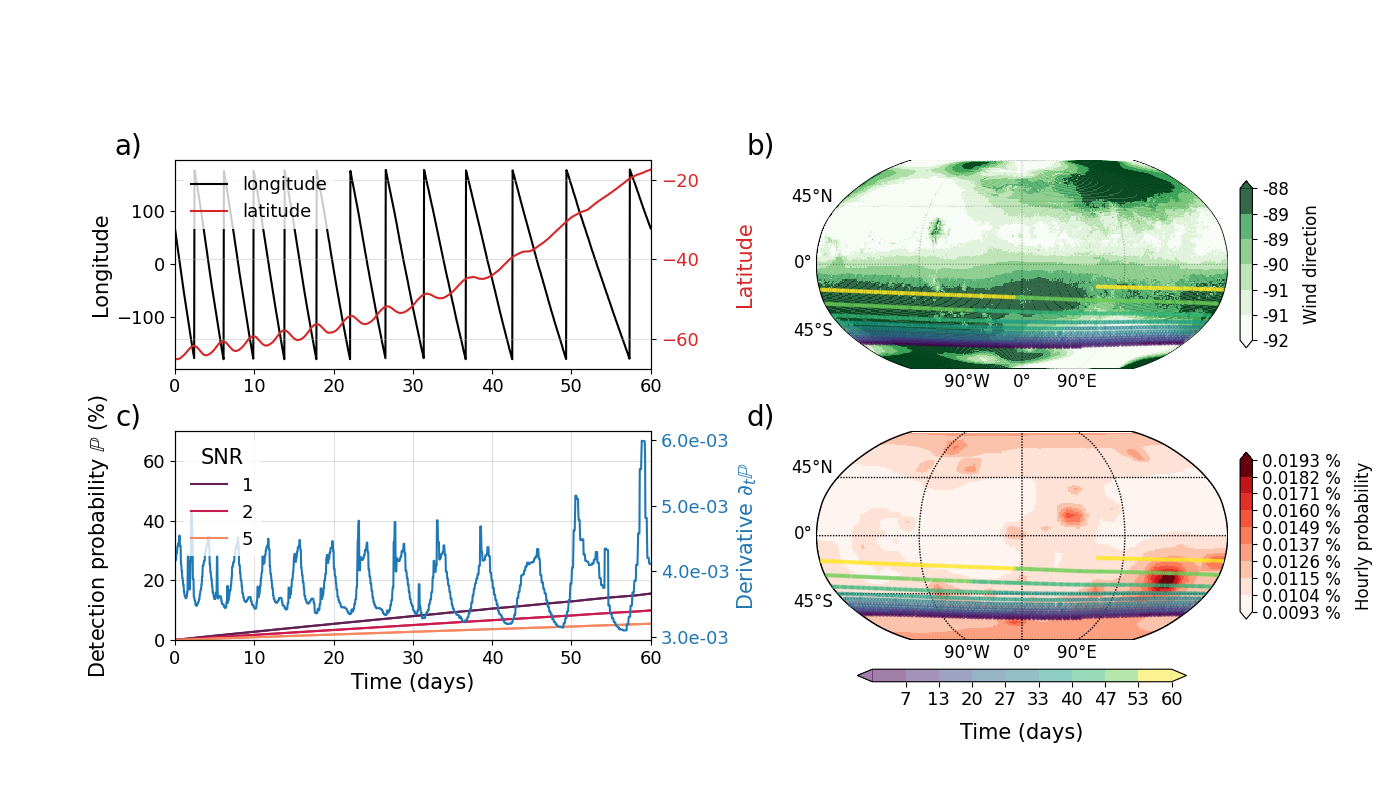

In [425]:
reload(pm)

opt_visualization = dict(
    VENUS=None,#pm.get_regions('../../../Venus_data/')
    snr=1., 
    n_colors=10, 
    c_cbar='black', 
    fontsize=15., 
    ylim=[0., 70.],
    plot_time=True,
    plot_volcanoes=False,
    n_colors_proba = 10, 
    n_colors_winds = 7,
    file = None
    #file='/staff/quentin/Documents/Projects/2024_Venus_Detectability/figures/Figure_2_balloon_proba_brune_1s.pdf'
    #file='/staff/quentin/Documents/Projects/2024_Venus_Detectability/figures/Figure_3_balloon_proba_1s_Hot40.pdf'
)

new_trajectories_total = new_trajectories.copy()
new_trajectories_total['seismicity'] = 'low'

####### WRINKLE RIDGES #######
#pm.plot_trajectory(new_trajectories_total, proba_model_wrinkles, winds, **opt_visualization)

####### TECTONIC #######
pm.plot_trajectory(new_trajectories_total, proba_model, winds, **opt_visualization)

### Prepare airglow final probas - Make sure to run probas model above (we are not using final_probas for airglow)

In [21]:
delta_time = 24*30
probas_dayglow = pd.DataFrame()
probas_nightglow = pd.DataFrame()

## Files generated above when computing map with airglow
for freq in [0.01, 0.1, 1.]:

    file = f'./data/final_probas/probas_dayglow_SNRnight1.0_SNRday1_same_event_mCold100_{freq}Hz_nobrune.csv'
    probas_dayglow_loc = pd.read_csv(file, header=[0])
    probas_dayglow_loc['freq'] = freq
    
    file = f'./data/final_probas/probas_nightglow_SNRnight1.0_SNRday1_same_event_mCold100_{freq}Hz_nobrune.csv'
    probas_nightglow_loc = pd.read_csv(file, header=[0])
    probas_nightglow_loc['freq'] = freq
    
    probas_dayglow_loc = probas_dayglow_loc.groupby('SNR', as_index=False).apply(lambda g: g.iloc[::delta_time]).reset_index(drop=True)
    probas_nightglow_loc = probas_nightglow_loc.groupby('SNR', as_index=False).apply(lambda g: g.iloc[::delta_time]).reset_index(drop=True)

    probas_dayglow = pd.concat([probas_dayglow, probas_dayglow_loc])
    probas_nightglow = pd.concat([probas_nightglow, probas_nightglow_loc])
    
def probas_airglow_func(day, snrs, probas_airglow):

    probas_hours = probas_airglow.hour.values
    probas_snrs = probas_airglow.SNR.values
    proba_idx = np.arange(probas_hours.size)
    requested_idx = np.arange(day.size)
    
    m_proba_idx, m_requested_idx = np.meshgrid(proba_idx, requested_idx)
    shape_m_idx = m_proba_idx.shape
    m_proba_idx, m_requested_idx = m_proba_idx.ravel(), m_requested_idx.ravel()
    
    idx_okay = abs(probas_hours[m_proba_idx]-day[m_requested_idx]*24).reshape(shape_m_idx)
    idx_okay += abs(probas_snrs[m_proba_idx]-snrs[m_requested_idx]).reshape(shape_m_idx)
    idx_okay = m_proba_idx[idx_okay.argmin(axis=1)]
    #print(probas_airglow.hour.values[idx_okay])
    #print(probas_airglow.SNR.values[idx_okay])
    #idx_okay_day = np.argmin(abs(probas_snrs[m_proba_idx]-snrs[m_requested_idx]))
    #idx_okay = (abs(probas_hours[m_proba_idx]-day[m_requested_idx]*24) < threshold_hour) & (abs(probas_snrs[m_proba_idx]-snrs[m_requested_idx]) < threshold_snr)
    #idx_okay = m_proba_idx[idx_okay]
    
    return probas_airglow.proba.values[idx_okay]

day = np.arange(30, 30*6, 30)
snrs = np.zeros_like(day)+1
probas_airglow_func(day, snrs, probas_nightglow)

array([0.10027586, 0.19270166, 0.27368604, 0.34804954, 0.41390883])

### Check availability of final probas files

In [15]:
import os

dir_probas = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/data/final_probas/'

scenario = 'active_low_min'
#vel_models = ['Cold100', 'Hot25']
vel_models = ['Cold100', 'Hot10', 'Hot25', 'Hot40']
#vel_models = ['Hot25',]
alts = [50., 55., 60., 65.]

periods = [1, 10, 100]

for vel_model in vel_models:
    for alt in alts:
        for period in periods:

            sensor_type = 'one_balloon_any_event'
            file = f'{dir_probas}final_probas_{sensor_type}_{scenario}_n0.01_alt{alt:.0f}_{period}s_{vel_model}_19.06.2025.csv'
            #final_probas_one_balloon_any_event_active_low_min_n0.01_alt60_100s_Cold100_newwinds.csv
            #final_probas_one_balloon_any_event_active_low_min_n0.01_alt60_100s_newwinds.csv
            #print(f'File {file}')
            if not os.path.exists(file):
                print('----')
                print(f'Missing file {file}')

            sensor_type = 'network_same_event'
            file = f'{dir_probas}final_probas_{sensor_type}_{scenario}_n0.01_alt{alt:.0f}_{period}s_{vel_model}_19.06.2025.csv'
            if not os.path.exists(file) and False:
                print('----')
                print(f'Missing file {file}')
            else:
                print('--> Found')

            sensor_type = 'network_any_event'
            file = f'{dir_probas}final_probas_{sensor_type}_{scenario}_n0.01_alt{alt:.0f}_{period}s_{vel_model}_19.06.2025.csv'
            if not os.path.exists(file) and False:
                print('----')
                print(f'Missing file {file}')

--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found
--> Found


In [60]:
from tqdm import tqdm

def filter_snrs(pd_final_probas_loc, snrs_selected):
    snr_available = pd_final_probas_loc.loc[:,'snr'].unique()
    snr_available = [snr_available[np.argmin(abs(snr-snr_available))] for snr in snrs_selected]
    pd_final_probas_loc = pd_final_probas_loc.loc[pd_final_probas_loc.snr.isin(snr_available)]
    return pd_final_probas_loc

pd_final_probas = pd.DataFrame()
pd_final_probas_airglow = pd.DataFrame()

dir_probas = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/data/final_probas/'

snrs_selected = [1., 2., 5.]

scenario = 'active_low_min'
#alts = [45, 55, 65]
alts = [50., 55., 60., 65.]

vel_models = ['Cold100', 'Hot40', 'Hot25', 'Hot10']
vel_model_highlight = 'Cold100'

periods = [1, 10, 100]

for alt in tqdm(alts):
    for period in periods:
        for vel_model in vel_models:

            ## comparison between balloon configurations
            sensor_type = 'one_balloon_any_event'
            pd_final_probas_loc = pd.read_csv(f'{dir_probas}final_probas_{sensor_type}_{scenario}_n0.01_alt{alt:.0f}_{period}s_{vel_model}_19.06.2025.csv')
            pd_final_probas_loc = filter_snrs(pd_final_probas_loc, snrs_selected)
            pd_final_probas_loc['seismicity'] = '1 balloon'
            pd_final_probas_loc['fmax'] = 1./period
            pd_final_probas_loc['vel_model'] = vel_model
            pd_final_probas = pd.concat([pd_final_probas, pd_final_probas_loc])

            sensor_type = 'network_same_event'
            pd_final_probas_loc = pd.read_csv(f'{dir_probas}final_probas_{sensor_type}_{scenario}_n0.01_alt{alt:.0f}_{period}s_{vel_model}_19.06.2025.csv')
            pd_final_probas_loc = filter_snrs(pd_final_probas_loc, snrs_selected)
            pd_final_probas_loc['seismicity'] = 'same event'
            pd_final_probas_loc['fmax'] = 1./period
            pd_final_probas_loc['vel_model'] = vel_model
            pd_final_probas = pd.concat([pd_final_probas, pd_final_probas_loc])
            pd_final_probas_balloons = pd_final_probas_loc.copy()

            sensor_type = 'network_any_event'
            pd_final_probas_loc = pd.read_csv(f'{dir_probas}final_probas_{sensor_type}_{scenario}_n0.01_alt{alt:.0f}_{period}s_{vel_model}_19.06.2025.csv')
            pd_final_probas_loc = filter_snrs(pd_final_probas_loc, snrs_selected)
            pd_final_probas_loc['seismicity'] = 'any event'
            pd_final_probas_loc['fmax'] = 1./period
            pd_final_probas_loc['vel_model'] = vel_model
            pd_final_probas = pd.concat([pd_final_probas, pd_final_probas_loc])

            ## comparison between airglow and balloons
            if not vel_model == vel_model_highlight:
                continue
                
            pd_final_probas_loc = pd_final_probas_balloons.copy()
            probas_nightglow_loc = probas_nightglow.loc[probas_nightglow.freq==1./period]
            pd_final_probas_loc.loc[:, 'proba'] = probas_airglow_func(pd_final_probas_loc.loc[:, 'duration'].values, pd_final_probas_loc.loc[:, 'snr'].values, probas_nightglow_loc)
            pd_final_probas_loc['seismicity'] = 'nightglow'
            pd_final_probas_loc['vel_model'] = vel_model
            pd_final_probas_airglow = pd.concat([pd_final_probas_airglow, pd_final_probas_loc])

            pd_final_probas_loc = pd_final_probas_balloons.copy()
            probas_dayglow_loc = probas_dayglow.loc[probas_dayglow.freq==1./period]
            pd_final_probas_loc.loc[:, 'proba'] = probas_airglow_func(pd_final_probas_loc.loc[:, 'duration'].values, pd_final_probas_loc.loc[:, 'snr'].values, probas_dayglow_loc)
            pd_final_probas_loc['seismicity'] = 'dayglow'
            pd_final_probas_loc['vel_model'] = vel_model
            pd_final_probas_airglow = pd.concat([pd_final_probas_airglow, pd_final_probas_loc])

            pd_final_probas_balloons['seismicity'] = 'balloons'
            pd_final_probas_airglow = pd.concat([pd_final_probas_airglow, pd_final_probas_balloons])

100%|██████████| 4/4 [00:54<00:00, 13.50s/it]


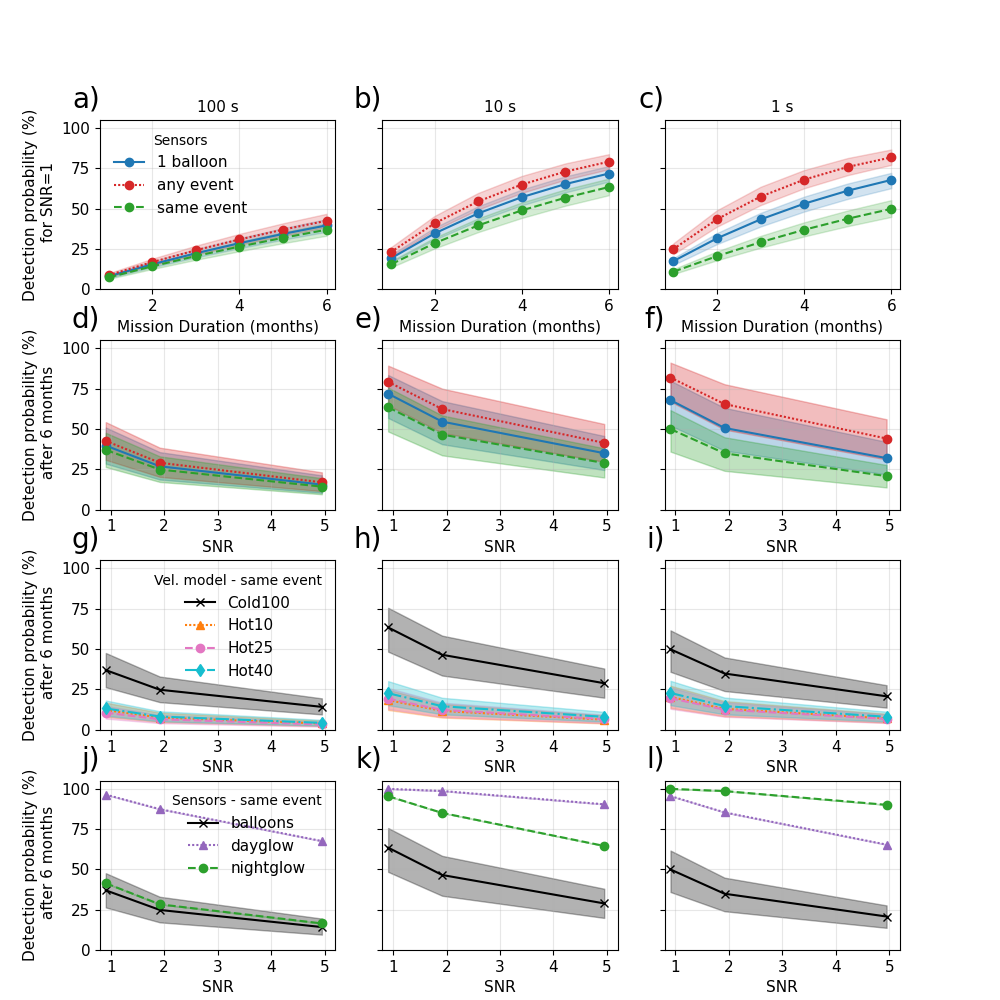

In [73]:
import string

def plot_proba_vs_duration(ax, alphabet, ifmax, fmax, pd_final_probas_fmax, snr_to_exclude, SNR_legend, seismicity_legend, fontsize_label, colors, ls, markers, color_labels, title_legend):
    
    snr_handles = []  # Handles for SNR legend
    seismicity_handles = []  # Handles for Seismicity legend

    for iseismicity, (seismicity, pd_final_probas_seismicity) in enumerate(pd_final_probas_fmax.groupby('seismicity')):

        for isnr, (snr, pd_final_probas_snr) in enumerate(pd_final_probas_seismicity.groupby('snr')):

            if snr in snr_to_exclude:
                continue

            duration = pd_final_probas_snr.duration.unique()
            probas = pd_final_probas_snr.groupby(['duration']).proba.median().reset_index().proba.values*1e2
            #qmin_probas = pd_final_probas_snr.groupby(['duration']).proba.min().reset_index().proba.values*1e2
            #qmax_probas = pd_final_probas_snr.groupby(['duration']).proba.max().reset_index().proba.values*1e2
            qmin_probas = pd_final_probas_snr.groupby(['duration']).proba.quantile(q=0.3).reset_index().proba.values*1e2
            qmax_probas = pd_final_probas_snr.groupby(['duration']).proba.quantile(q=0.7).reset_index().proba.values*1e2

            label_dict = dict()
            if iseismicity == 0 and ifmax == 0:
                snr_label = f'{snr:.0f}'
                label_dict = dict(label=snr_label)
                snr_handles.append(ax.plot([], [], marker=markers[iseismicity], color=colors[iseismicity], label=snr_label)[0])

            if ifmax == 0 and isnr == 0:
                seismicity_label = f'{seismicity}'
                seismicity_handles.append(ax.plot([], [], color=colors[iseismicity], marker=markers[iseismicity], label=seismicity_label, ls=ls[iseismicity])[0])

            ax.plot(duration/30., probas, marker=markers[iseismicity], color=colors[iseismicity], ls=ls[iseismicity], **label_dict)
            ax.fill_between(duration/30., qmin_probas, qmax_probas, color=colors[iseismicity], alpha=0.2)

    ax.tick_params(axis='both', colors=color_labels, labelsize=fontsize_label)
    if ifmax == 0 and SNR_legend:
        legend1 = ax.legend(handles=snr_handles, frameon=False, title='SNR', fontsize=fontsize_label, loc='upper right',)
        ax.add_artist(legend1)  # Add the first legend to the axis

    if ifmax == 0 and seismicity_legend:
        # Add the second legend for Seismicity
        ax.legend(handles=seismicity_handles, frameon=False,  title='Sensors', fontsize=fontsize_label, loc='upper left')
        #ax.legend(frameon=False, title='Seismicity', fontsize=fontsize_label, loc='upper right')

    if ifmax == 0:
        ax.set_ylabel('Detection probability (%)\n for SNR=1', color=color_labels, fontsize=fontsize_label)

    if ifmax > 0:
        ax.tick_params(axis='both', labelleft=False)

    ax.text(-0., 1.04, f'{alphabet[ifmax]})', fontsize=20., ha='right', va='bottom', transform=ax.transAxes)
    ax.set_xlabel('Mission Duration (months)', color=color_labels, fontsize=fontsize_label)
    ax.set_xlim([0.8, 6.2])
    ax.set_ylim([0, 100.])
    ax.set_title(f'{1./fmax:.0f} s', fontsize=fontsize_label, color=color_labels)
    ax.grid(alpha=0.3)

def plot_proba_vs_snr(ax, alphabet, ifmax, fmax, pd_final_probas_fmax, snr_to_exclude, SNR_legend, seismicity_legend, fontsize_label, colors, ls, markers, color_labels, title_legend, offset_alphabet, col_chosen='seismicity'):
    
    snr_handles = []  # Handles for SNR legend
    seismicity_handles = []  # Handles for Seismicity legend

    for iseismicity, (seismicity, pd_final_probas_seismicity) in enumerate(pd_final_probas_fmax.groupby(col_chosen)):

        #for isnr, (snr, pd_final_probas_snr) in enumerate(pd_final_probas_seismicity.groupby('snr')):
        isnr = 0
        #snr = snr_selected
        pd_final_probas_snr = pd_final_probas_seismicity.loc[(pd_final_probas_seismicity.duration==pd_final_probas_seismicity.duration.max())]
        snrs = pd_final_probas_snr.snr.unique()
        probas = pd_final_probas_snr.groupby(['snr']).proba.median().reset_index().proba.values*1e2
        #print(seismicity, probas)
        qmin_probas = pd_final_probas_snr.groupby(['snr']).proba.min().reset_index().proba.values*1e2
        qmax_probas = pd_final_probas_snr.groupby(['snr']).proba.max().reset_index().proba.values*1e2

        #if ifmax == 0 and isnr == 0:
        #    seismicity_label = f'{seismicity}'
        #    seismicity_handles.append(ax.plot([], [], '--', color='black', label=seismicity_label, ls=ls[iseismicity])[0])

        seismicity_label = dict()
        if ifmax == 0:
            seismicity_label['label'] = f'{seismicity}'

        ax.plot(snrs, probas, marker=markers[iseismicity], color=colors[iseismicity], ls=ls[iseismicity], **seismicity_label)
        ax.fill_between(snrs, qmin_probas, qmax_probas, color=colors[iseismicity], alpha=0.3)

    ax.tick_params(axis='both', colors=color_labels, labelsize=fontsize_label)

    if ifmax == 0 and seismicity_legend:    
        ax.legend(frameon=False, title=title_legend, fontsize=fontsize_label, loc='upper right')
    #if ifmax == 0 and seismicity_legend:
    #    ax.legend(frameon=False, title='Network', fontsize=fontsize_label, loc='upper left')

    if ifmax == 0:
        ax.set_ylabel('Detection probability (%)\n after 6 months', color=color_labels, fontsize=fontsize_label)

    if ifmax > 0:
        ax.tick_params(axis='both', labelleft=False)

    ax.text(-0., 1.04, f'{alphabet[ifmax+offset_alphabet]})', fontsize=20., ha='right', va='bottom', transform=ax.transAxes)
    ax.set_xlabel('SNR', color=color_labels, fontsize=fontsize_label)
    ax.set_xlim([0.8, 5.2])
    ax.set_ylim([0, 100.])
    #ax.set_title(f'{1./fmax:.0f} s', fontsize=fontsize_label, color=color_labels)
    ax.grid(alpha=0.3)


def plot_proba_statistics_no_distrib(pd_final_probas, pd_final_probas_airglow, vel_model_highlight, color_labels='black', fontsize_label=11., file=None, SNR_legend=True, seismicity_legend=False, snr_to_exclude=[], ylim=[0., 105]):

    alphabet = string.ascii_lowercase
    colors = ['tab:blue', 'tab:red', 'tab:green']
    ls = ['-', (0, (1, 1)), '--']
    markers = ['o', 'o', 'o']
    fmaxs = pd_final_probas.fmax.unique()
    title_legend = 'Sensors'

    fig = plt.figure(figsize=(3*fmaxs.size+1,10))
    grid = fig.add_gridspec(4, fmaxs.size)
    
    for ifmax, (fmax, pd_final_probas_fmax_global) in enumerate(pd_final_probas.groupby('fmax')):

        pd_final_probas_fmax = pd_final_probas_fmax_global.loc[pd_final_probas_fmax_global.vel_model==vel_model_highlight]
        
        ## duration vs proba
        ax = fig.add_subplot(grid[0, ifmax])
        rect = plt.Rectangle(
            (0, 0), 1, 1,
            transform=ax.transAxes,  # Use axes coordinates
            color='white',
            zorder=-1,  # Place it below all other elements
        )
        ax.add_patch(rect)
        
        plot_proba_vs_duration(ax, alphabet, ifmax, fmax, pd_final_probas_fmax, snr_to_exclude, False, True, fontsize_label, colors, ls, markers, color_labels, title_legend)
        ax.set_ylim(ylim)
        
        ## SNR vs proba
        ax = fig.add_subplot(grid[1, ifmax])
        rect = plt.Rectangle(
            (0, 0), 1, 1,
            transform=ax.transAxes,  # Use axes coordinates
            color='white',
            zorder=-1,  # Place it below all other elements
        )
        ax.add_patch(rect)
        plot_proba_vs_snr(ax, alphabet, ifmax, fmax, pd_final_probas_fmax, snr_to_exclude, False, False, fontsize_label, colors, ls, markers, color_labels, title_legend, 3)
        ax.set_ylim(ylim)
        
    markers = ['x', '^', 'o', 'd']
    colors = ['black', 'tab:orange', 'tab:pink', 'tab:cyan']
    ls = ['-', (0, (1, 1)), '--', '-.']
    title_legend = 'Vel. model - same event'
    for ifmax, (fmax, pd_final_probas_fmax) in enumerate(pd_final_probas.loc[pd_final_probas.seismicity=='same event'].groupby('fmax')):
        
        ## SNR vs proba
        ax = fig.add_subplot(grid[2, ifmax])
        rect = plt.Rectangle(
            (0, 0), 1, 1,
            transform=ax.transAxes,  # Use axes coordinates
            color='white',
            zorder=-1,  # Place it below all other elements
        )
        ax.add_patch(rect)
        #plot_proba_vs_snr_vel(ax, alphabet, ifmax, fmax, pd_final_probas_fmax, snr_to_exclude, False, True, fontsize_label, colors, ls, markers, color_labels, title_legend, 9)
        plot_proba_vs_snr(ax, alphabet, ifmax, fmax, pd_final_probas_fmax, snr_to_exclude, False, True, fontsize_label, colors, ls, markers, color_labels, title_legend, 6, col_chosen='vel_model')
        ax.set_ylim(ylim)
        
    markers = ['x', '^', 'o']
    colors = ['black', 'tab:purple', 'tab:green']
    title_legend = 'Sensors - same event'
    for ifmax, (fmax, pd_final_probas_fmax) in enumerate(pd_final_probas_airglow.groupby('fmax')):
        
        ## SNR vs proba
        ax = fig.add_subplot(grid[3, ifmax])
        rect = plt.Rectangle(
            (0, 0), 1, 1,
            transform=ax.transAxes,  # Use axes coordinates
            color='white',
            zorder=-1,  # Place it below all other elements
        )
        ax.add_patch(rect)
        plot_proba_vs_snr(ax, alphabet, ifmax, fmax, pd_final_probas_fmax, snr_to_exclude, False, True, fontsize_label, colors, ls, markers, color_labels, title_legend, 9)
        ax.set_ylim(ylim)
        
    
        
    fig.subplots_adjust(left=0.1, bottom=0.05, hspace=0.3)
        
    if file is not None:
        fig.savefig(file, transparent=True)

snr_available = pd_final_probas.snr.unique()
snr_to_exclude = [snr_available[np.argmin(abs(snr_available-snr))] for snr in [2, 5]]
file = f'/staff/quentin/Documents/Projects/2024_Venus_Detectability/figures/Figure_4_statistics_sensors_velmodel.pdf'
#file = None
plot_proba_statistics_no_distrib(pd_final_probas, pd_final_probas_airglow, vel_model_highlight, color_labels='black', file=file, SNR_legend=True, seismicity_legend=True, snr_to_exclude=snr_to_exclude)

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcol
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.basemap import Basemap

def plot_proba_trajectories_map(pd_final_probas, cmap_bounds=np.linspace(0., 0.8, 15)):

    lats = pd_final_probas.lat.unique()
    lons = pd_final_probas.lon.unique()
    mission_durations = pd_final_probas.duration.unique()
    LONS, LATS = np.meshgrid(lons, lats)

    cmap = cm.get_cmap("Reds", lut=len(cmap_bounds))
    norm = mcol.BoundaryNorm(cmap_bounds, cmap.N)
        
    fig = plt.figure(figsize=(10,10))
    grid = fig.add_gridspec(len(mission_durations), 3)
    iduration = -1
    for duration, one_duration in pd_final_probas.groupby('duration'):
        iduration += 1
        isnr = -1
        for snr, one_snr in one_duration.groupby('snr'):
            isnr +=1
            field = one_snr.proba.values.reshape(lons.size, lats.size)
            
            
            ax = fig.add_subplot(grid[iduration, isnr])
            m = Basemap(projection='robin', lon_0=0, ax=ax)
            m.drawmeridians(np.linspace(-180., 180., 5), labels=[0, 0, 0, 1], fontsize=10,)
            m.drawparallels(np.linspace(-90., 90., 5), labels=[1, 0, 0, 0], fontsize=10,)
            x, y = m(LONS.ravel(), LATS.ravel())
            x, y = x.reshape(LONS.shape), y.reshape(LONS.shape)
            sc = m.pcolormesh(x, y, field.T, cmap=cmap, norm=norm)
            #plt.colorbar(sc)
            plt.title(f'SNR {snr} - {duration:.0f} days')

    fmt = lambda x, pos: '{:.2f} %'.format(x*1e2) # 
    axins = inset_axes(ax, width="6%", height="250%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
    axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    cbar = fig.colorbar(sc, format=FuncFormatter(fmt), cax=axins, orientation='vertical', extend='both', ticks=cmap_bounds[1:],)

plot_proba_trajectories_map(pd_final_probas, cmap_bounds=np.linspace(0., 0.8, 15))

In [ ]:
import string

def plot_proba_trajectories(pd_final_probas, file=None, times_airglow=None, probas_dayglow=None, probas_nightglow=None, color_labels='black'):

    plot_airglow = True
    offset_airglow = 1
    if times_airglow is None:
        plot_airglow = False
        offset_airglow = 0

    c_dayglow = 'tab:red'
    c_nightglow = 'black'
    mission_durations = pd_final_probas.duration.unique()
    alphabet = string.ascii_lowercase

    fig = plt.figure(figsize=(14,3))
    grid = fig.add_gridspec(1, len(mission_durations)+offset_airglow)
    iduration = -1
    axs = []
    for duration, one_duration in pd_final_probas.groupby('duration'):
        iduration += 1
        ax = fig.add_subplot(grid[0, iduration])
        axs.append(ax)
        #print(duration)
        if plot_airglow:
            iairglow = np.argmin(abs(times_airglow-duration/30.))
            ax.axvline(probas_dayglow[iairglow], color=c_dayglow, lw=3., alpha=0.75, zorder=1)
            ax.axvline(probas_nightglow[iairglow], color=c_nightglow, lw=3., alpha=0.75, zorder=1)
        ax.set_title(f'Mission {duration/30.:.1f} months', color=color_labels)
        for snr, one_snr in one_duration.groupby('snr'):
            #values, bins = np.histogram(one_snr.proba, bins=20)
            #bin_centers = 0.5 * (bins[:-1] + bins[1:])
            #ax.bar(bin_centers, values/, width=(bins[1] - bins[0]), label=snr)
            ax.hist(one_snr.proba, bins=10, label=snr, density=True, zorder=10)
        ax.set_xlabel('Detection Probability', color=color_labels)
        if iduration == 0:
            ax.legend(title='SNR', frameon=False)
            ax.set_ylabel('Probability Density Function', color=color_labels)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 40.])

        fontsize_label = 20.
        ax.text(-0.1, 1., f'{alphabet[iduration]})', fontsize=fontsize_label, ha='right', va='bottom', transform=ax.transAxes)

    if plot_airglow:
        ax = fig.add_subplot(grid[0, -1])
        ax.plot(times_airglow, probas_dayglow, color=c_dayglow, lw=3., alpha=0.5, label='dayglow')
        ax.plot(times_airglow, probas_nightglow, color=c_nightglow, lw=3., alpha=0.5, label='nightglow')
        ax.legend(frameon=False)
        ax.set_xlabel('Airglow mission duration', color=color_labels)
        ax.set_ylabel('Detection probability', color=color_labels)

    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2,)
    if file is not None:
        for ax in axs:
            rect = plt.Rectangle(
                (0, 0), 1, 1,
                transform=ax.transAxes,  # Use axes coordinates
                color='white',
                zorder=-1,  # Place it below all other elements
            )
            ax.add_patch(rect)
            ax.tick_params(axis='both', colors=color_labels)
        fig.savefig(file, transparent=True)

def logistic(x, x0, std, L=1.):
    k = 1./std
    return L/(1+np.exp(-(x-x0)*k))

#times_airglow = np.linspace(0., 2., 100)*12
#probas_dayglow = logistic(times_airglow, 1.*12., 0.5*12., L=1.)
#probas_nightglow = logistic(times_airglow, 1.5*12., 0.7*12., L=1.)
#plot_proba_trajectories(pd_final_probas, times_airglow, probas_dayglow, probas_nightglow)
file = f'/staff/quentin/Documents/Projects/2024_Venus_Detectability/figures/statistics_one_balloon_AGU_new.png'
#file = f'/staff/quentin/Documents/Projects/2024_Venus_Detectability/figures/Figure_4_statistics_one_balloon.pdf'
file = None
plot_proba_trajectories(pd_final_probas, file=file, color_labels='black')

### Wrinkle Ridges - map

In [ ]:
PATH_VENUS_DATA = os.path.join("./data/")
PATH_VENUS = os.path.join(f"{PATH_VENUS_DATA}wrinkle_ridges")
VENUS = dict(wrinkles=gpd.read_file(f"{PATH_VENUS}/wrinkle_ridges.shp"))

In [ ]:
reload(pm)

opt_visualization = dict(
    VENUS = VENUS,
    c_cbar = 'black', 
    l_snr_to_plot = [1.,2.5], 
    n_colors = 10,
    plot_all_regions = True,
    use_active_corona = True
)

## active low
opt_visualization.update(dict(
    low_cmap = np.arange(0.1, 0.15, 0.025), # 1 day RW wrinkles
    high_cmap = np.arange(0.15, 0.33, 0.025),))

pm.plot_map(proba_model_wrinkles, **opt_visualization)

### Wrinkle Ridges - trajectories

In [ ]:
reload(pm)

lats = np.linspace(-65., 65., 25)
lons = np.linspace(-180., 179., 30)
mission_durations = [15., 30., 45., 60.]
pd_final_probas_wrinkles = pm.compute_multiple_trajectories(proba_model_wrinkles, winds, lats, lons, mission_durations)

In [ ]:
reload(pm)

pm.plot_maps_all_trajectories(pd_final_probas_wrinkles, lons, lats, mission_durations, cmap_bounds=np.linspace(0., 0.1, 15))

In [ ]:
reload(pm)

pm.plot_proba_all_trajectories(pd_final_probas_wrinkles, mission_durations, xlim=[0, 0.1], ylim=[0, 150.])

In [ ]:
reload(pm)

new_trajectories = pm.compute_proba_one_trajectory(trajectory, proba_model_wrinkles, norm_factor_time=3600.) ## Wrinkles

In [ ]:
reload(pm)

opt_visualization = dict(
    VENUS=None,
    snr=2., 
    n_colors=10, 
    c_cbar='black', 
    fontsize=15., 
    ylim=[0., 75.],
    plot_time=True,
    plot_volcanoes=False
)

new_trajectories_total = new_trajectories.copy()
new_trajectories_total['seismicity'] = 'low'
pm.plot_trajectory(new_trajectories_total, proba_model_wrinkles, winds, **opt_visualization)

### Volcanoes - trajectories

In [ ]:
reload(pm)

opt_visualization = dict(
    VENUS=None,#pm.get_regions('../../../Venus_data/')
    snr=1., 
    n_colors=10, 
    c_cbar='black', 
    fontsize=15., 
    ylim=[0., 20.],
    plot_time=True,
    plot_volcanoes=True
)

new_trajectories_total = new_trajectories.copy()
new_trajectories_total['seismicity'] = 'low'
pm.plot_trajectory(new_trajectories_total, proba_model_volcanoes, **opt_visualization)

## Visualize internal PDFs (i.e., step by step process) 

In [ ]:
mag, dist = 5., 1000.

imag = np.argmin(abs(M0s-mag))
iloc = 9
isnr = 5

durations = np.linspace(1./365., 100./365., 50)
DUR, THRESH = np.meshgrid(durations, SNR_thresholds)
proba_durations = np.zeros((durations.size,)+proba.shape)
for iduration, duration in enumerate(durations):
    proba_durations[iduration,:,:] = compute_Poisson(DISTS, MAG, DETECT_T, RATIOs, F_MAGS, m_min, duration, pd_slopes, scenario, rates=rates)

fig = plt.figure(figsize=(16,3))
grid = fig.add_gridspec(1, 6)

ax = fig.add_subplot(grid[0, 0])
for dist in [500., 1000.]:
    idist = np.argmin(abs(dists-dist))
    #sigma = sigma_TL/noise_level
    #mu = TL(dists[idist], M0s[imag])/noise_level
    mu = compute_TL(dists[idist], M0s[imag])/noise_level
    sigma = mu*(10**sigma_TL - 1.)
    ax.plot(SNR_thresholds, (1./(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((SNR_thresholds-mu)/sigma)**2))
ax.set_title(M0s[imag])

ax = fig.add_subplot(grid[0, 1])
#ax.plot(detection_thresholds, cum_pdf[imag, idist, :, iloc])
test_cum = 0.5*(1+special.erf( (SNR_thresholds-mu)/(sigma*np.sqrt(2.)) ))
ax.plot(SNR_thresholds, 1-test_cum)
ax.set_ylim([0.,1])

ax = fig.add_subplot(grid[0, 2])
for rate in rates:
    ax.plot(SNR_thresholds, rate[:,iloc])
ax.set_yscale('log')

ax = fig.add_subplot(grid[0, 3])
ax.pcolormesh(THRESH, DUR*12, proba_durations[:,:,iloc].T, vmax=1., vmin=0.)
ax.set_title(f'lat/lon: {lats[iloc]:.2f}/{lons[iloc]:.2f}')
#ax.plot(proba_durations[20,:,iloc])
#ax.set_ylim([-0.,1.1])

ax = fig.add_subplot(grid[0, 4])
for region in RATIOs:
    ax.plot(dists, RATIOs[region].reshape(shape_init)[0,:,0,iloc])
    
ax = fig.add_subplot(grid[0, 5])
sc = ax.pcolormesh(all_lons, all_lats, proba_all_other[isnr,:])
#sc = ax.plot(lats_orig, proba_all_other[isnr,:,ilon])
ax.set_title(f'SNR: {SNR_thresholds[isnr]:.2f}')
plt.colorbar(sc)
#ax.set_ylim([0.,1.1])

## Plot schematic

In [ ]:
import matplotlib.patches as patches
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k")
    

compute_TL = lambda dist, alpha, M0: M0*10*dist**(-alpha)
compute_SNR = lambda dist, alpha, M0, noise_level: compute_TL(dist, alpha, M0)/noise_level
compute_distrib = lambda SNR, sigma_TL, dist, alpha, M0, noise_level: np.exp(-((SNRs-compute_SNR(dist, alpha, M0, noise_level))/sigma_TL)**2) 
SNRs=np.linspace(0., 5, 100)
dists=[100, 200, 500]
sigma_TL=0.3
noise_level=0.1
alpha=0.7
SNR_t=2.5
l_dists = np.linspace(10., 1100., 100)
plt.rcParams['text.usetex'] = False
def plot_TL_vs_distance(ax, M0=1):
    for idist, dist in enumerate(dists):
        one_distrib = compute_distrib(SNRs, sigma_TL, dist, alpha, M0, noise_level)
        factor = 500.
        label = {}
        if idist == 0:
            label['label'] = 'f_{TL}($M_0$) = TL($M_0$)/$\sigma_n$'
        plt.plot(factor*one_distrib+dist, SNRs, zorder=10, color='tab:blue', **label)
        #plt.plot(factor*one_distrib, SNRs)
        
        if idist < 2:
            i_last_SNR = np.argmin(abs(SNRs-SNR_t))
            shape_dist = np.r_[one_distrib[i_last_SNR:], np.array([0., one_distrib[i_last_SNR]])]
            shape_SNR = np.r_[SNRs[i_last_SNR:], np.array([SNR_t, SNR_t])]
            ax.fill(factor*shape_dist+dist, shape_SNR, alpha=0.5, color='tab:blue')
        
    
    ax.plot(l_dists, compute_SNR(l_dists, alpha, M0, noise_level), zorder=1, alpha=0.1, linewidth=3., color='black')
    ax.axhline(SNR_t, color='tab:blue', zorder=2, alpha=0.5, linestyle=':')
    ax.set_ylim([SNRs.min(), SNRs.max()])
    ax.set_xlim([l_dists.min(), l_dists.max()])
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('SNR')
    ax.legend(frameon=False)

fig = plt.figure(figsize=(14,4))
grid = fig.add_gridspec(1, 3)

ax = fig.add_subplot(grid[0, 0])
plot_TL_vs_distance(ax)
eq2 = ("$\int_{SNR=d}^\infty f_{TL}(SNR=d,M_0,r)dSNR$")
ax.text(0.9, -0.35, eq2, color="C0", fontsize=16, transform=ax.transAxes, ha='center')

ax = fig.add_subplot(grid[0, 1])
test_cum = 0.5*(1+special.erf( (SNR_t-compute_SNR(l_dists, alpha, 2, noise_level))/(sigma_TL*np.sqrt(2.)) ))
ax.plot(l_dists, 1-test_cum, color='tab:orange')
ax.fill_between(l_dists, 1-test_cum, alpha=0.5, color='tab:orange', label='$M_1$')
test_cum = 0.5*(1+special.erf( (SNR_t-compute_SNR(l_dists, alpha, 1., noise_level))/(sigma_TL*np.sqrt(2.)) ))
ax.plot(l_dists, 1-test_cum, color='tab:blue')
ax.fill_between(l_dists, 1-test_cum, alpha=0.5, color='tab:blue', label='$M_0$')
ax.set_xlabel('Distance (km)')
ax.set_ylabel('$\mathbb{P}(SNR>d|M_0,r)$')
ax.legend(frameon=False)
eq2 = ("$\int_{M_0=M_{min}}^{M_{max}}\int_{r=0}^{r_{venus}}\mathbb{P}(SNR>d|M_0,r)f_{M}^{tec}(M_0)f^{tec}_{R}(r)drdM_0$")
ax.text(1.4, -0.35, eq2, color="C0", fontsize=16, transform=ax.transAxes, ha='center')
arrow = patches.FancyArrowPatch((-0.3, -0.15), (0.1, -0.15), connectionstyle="arc3,rad=.2", transform=ax.transAxes, clip_on=False, **kw)
ax.add_patch(arrow)

if True:
    ax = fig.add_subplot(grid[0, 2])
    iloc = 10
    iregion = 0
    ax.plot(SNR_thresholds, rate[iregion][:,iloc]/Nquake_over_mag(m_min, iregion), label='Region 0', color='tab:green')
    iregion = 1
    ax.plot(SNR_thresholds, rate[iregion][:,iloc]/Nquake_over_mag(m_min, iregion), label='Region 1', color='tab:pink')

    ax.set_ylabel('$\mathbb{P}(SNR>d|tec)$')
    ax.set_xlabel('d (SNR)')

    arrow = patches.FancyArrowPatch((-0.3, -0.15), (0.1, -0.15), connectionstyle="arc3,rad=.2", transform=ax.transAxes, clip_on=False, **kw)
    ax.add_patch(arrow)
    
    ax.legend(frameon=False)

fig.subplots_adjust(bottom=0.3)
fig.savefig('./schematic_proba_model.pdf')